Our own DEG analysis for Chen et al., (2020).  From their text they had several adhoc steps and refused to publish or share code.  Relevant publication: [Law, Charity W., Kathleen Zeglinski, Xueyi Dong, Monther Alhamdoosh, Gordon K. Smyth, and Matthew E. Ritchie. "A guide to creating design matrices for gene expression experiments." F1000Research 9 (2020).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7873980/) also see the [Limma User Guide](https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf).  Section 9.5 in particular has an explanation of making contrasts for interaction terms which could be usefull.  
<br>
This publication maybe interesting as well: https://www.nature.com/articles/s41467-021-25960-2  
<br>
This may also be useful: https://github.com/hbc/knowledgebase/blob/master/scrnaseq/pseudobulkDE_edgeR.md

In [37]:
library(randomForest)
library(rfUtilities)
library(stringr)
library(sampler)
library(caTools)
library(pROC)
library(ggplot2)
library(stats)
library(Dict)
library(pheatmap)
library(caret)
library(data.table)
library(dplyr)
library(lme4)
library(edgeR)
library(tictoc)

In [2]:
#Chen
chen2020_counts <- read.csv('~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/GSE152632_GEO_mberkchen_TRAP2_counts.csv.gz', header = TRUE)
rownames(chen2020_counts) <- chen2020_counts$X
chen2020_counts <- chen2020_counts[,2:3531]
chen2020_meta <- read.csv( '~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/SraRunTable.txt', header = TRUE)

#add engram label
chen2020_meta$engram_label <-  as.factor(sapply(as.character(colnames(chen2020_counts)), function(y) if (grepl("_pos_", y, fixed=TRUE)) "tdT+" else "tdT-"))

#create the condition label
condition_label <- chen2020_meta$source_name %>%
  sapply( function(y) if (grepl("Homecage", y, fixed=TRUE)) "Homecage")

condition_label <- chen2020_meta$source_name
condition_label[str_detect(condition_label, "Homecage")] = "Homecage"
condition_label[str_detect(condition_label, "Context-Only")] = "Context-Only"
condition_label[str_detect(condition_label, "Fear-Only")] = "Fear-Only"
condition_label[str_detect(condition_label, "Fear-Recall")] = "Fear-Recall"
chen2020_meta$condition_label <- condition_label

#adding cell bacrcodes from coutn data to rows of metadata for seurat
rownames(chen2020_meta) <- colnames(chen2020_counts)


chen2020_meta <- cbind(chen2020_meta, read.csv("~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/Chen2020_ClusterMarkers.csv") )
         
###

In [491]:
# gene filtering
# Filter out rows with less than 10 columns with values greater than 1
genefilter <- rowSums(chen2020_counts > 0) >= 10 # removes about 3k genes
cellfilter <- colSums(chen2020_counts > 0) >= 100 # doesn't change anything

In [494]:
# to preserve the original data
chen_og <- chen2020_counts

# now we filter
chen2020_counts <- chen2020_counts[genefilter,cellfilter]

In [3]:
# Subset the data frame to remove genes expressed in less than 10 samples
df_filtered <- df[!expressed_less_than_10, ]

In [15]:
# Create a list to store the masks
masks <- list()

# Iterate through each unique combination of source_name, broad_cell_types, and engram_label
for (i in unique(chen2020_meta$source_name)) {
  for (j in unique(chen2020_meta$BroadCellTypes)) {
    for (k in unique(chen2020_meta$engram_label)) {
      # Create a boolean mask for each unique combination
      mask <- chen2020_meta$source_name == i & chen2020_meta$BroadCellTypes == j & chen2020_meta$engram_label == k
      print(sum(mask))
      # Name the mask after the unique combination
      name <- paste(i, j, k, sep = "_")
      print(name)
      # Store the mask in the list
      masks[[name]] <- mask
      # Print the name of the mask
    }
  }
}


[1] 32
[1] "m5_Homecage_Excitatory_tdT-"
[1] 65
[1] "m5_Homecage_Excitatory_tdT+"
[1] 9
[1] "m5_Homecage_Inhibitory_tdT-"
[1] 28
[1] "m5_Homecage_Inhibitory_tdT+"
[1] 55
[1] "m5_Context-Only_Excitatory_tdT-"
[1] 39
[1] "m5_Context-Only_Excitatory_tdT+"
[1] 10
[1] "m5_Context-Only_Inhibitory_tdT-"
[1] 1
[1] "m5_Context-Only_Inhibitory_tdT+"
[1] 61
[1] "m2_Context-Only_Excitatory_tdT-"
[1] 101
[1] "m2_Context-Only_Excitatory_tdT+"
[1] 16
[1] "m2_Context-Only_Inhibitory_tdT-"
[1] 35
[1] "m2_Context-Only_Inhibitory_tdT+"
[1] 113
[1] "m2_Fear-Only_Excitatory_tdT-"
[1] 94
[1] "m2_Fear-Only_Excitatory_tdT+"
[1] 33
[1] "m2_Fear-Only_Inhibitory_tdT-"
[1] 6
[1] "m2_Fear-Only_Inhibitory_tdT+"
[1] 31
[1] "m1_Fear-Recall_Excitatory_tdT-"
[1] 43
[1] "m1_Fear-Recall_Excitatory_tdT+"
[1] 26
[1] "m1_Fear-Recall_Inhibitory_tdT-"
[1] 75
[1] "m1_Fear-Recall_Inhibitory_tdT+"
[1] 8
[1] "m1_Fear-Only_Excitatory_tdT-"
[1] 11
[1] "m1_Fear-Only_Excitatory_tdT+"
[1] 4
[1] "m1_Fear-Only_Inhibitory_tdT-"
[1] 13
[1

In [44]:
genes <- rownames(chen2020_counts)

# create matrix to fill
pseudobulk <- matrix(0, nrow = length(genes), ncol = length(masks))
pseudobulk <- as.data.frame(pseudobulk)
rownames(pseudobulk) <- genes
colnames(pseudobulk) <- names(masks)

In [54]:
# pseudobulk our samples
for (sample in names(masks)) {

    #get mask to filter counts matrix cell-wise (col wise) by
    these_cols <- masks[[sample]]
    
    # we need to handle exceptions otherwise rowSums throws errors
    # it needs a 2d array which can't happen in a no cell case or a 1 cell case
    # we should consider removing these cases enttirely
    # we 
    if(sum(these_cols)==0){
        # do nothing in this case, but convert column to integer to avoid errors later
        pseudobulk[,sample] <- as.integer(pseudobulk[,sample])
        }else if(sum(these_cols)==1){
        # 
        pseudobulk[,sample] <- as.integer(chen2020_counts[, these_cols])
    }else{
    pseudobulk[,sample] <- as.integer( rowSums(chen2020_counts[, these_cols]) ) }
}

In [69]:
multi.sub <- function(findthis, replacewith, x.vec){
    # replaces an entry containing a string matching an entry in findthis in x.vec with a corresponding entry in replacewith
    
    # seq_along returns enumerates integers from 1 to length of input list
    # loops over list of things to find
    for(i in seq_along(findthis)){
    #masks vector where 
    x.vec[grepl(findthis[i], x.vec)] <- replacewith[i]}
    return(x.vec)
    }

In [74]:
# since we are finding a pattern in the pseudobulk_meta titles and replacing each entry wiht that pattern we would have to enter the vector twice
# now we make a function so we only have to enter each list once making our code a little more legible
fun <- function(my_list, dfcol){
    factors.list <- unique(dfcol)
    return( multi.sub(factors.list, factors.list, my_list) )
    }

In [81]:
pseudobulk_meta <-  data.frame(celltype =  as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$BroadCellTypes) ) ) ),
                               condition = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$condition_label) ) ) ),
                               TRAPed = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$engram_label) ) ) ),
                               replicate = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$source_name) ) ) )
                               )

In [83]:
levels(pseudobulk_meta$TRAPed) <- c('positive', 'negative') # the labelled neurons get levels named 1 and 2 so this makes the dataframe more interpretable

In [113]:
n_cells <- list()
for(i in seq_along( names(masks) )){n_cells <- append(n_cells, sum(masks[[i]]))}
pseudobulk_meta$n_cells <- as.integer(n_cells) # adding cell counts to dataframe
rm(n_cells) # deleting unneeded variable

In [122]:
mean(pseudobulk_meta$n_cells[pseudobulk_meta$celltype=='Inhibitory'])

[1] 25.7

In [124]:
mean(pseudobulk_meta$n_cells[pseudobulk_meta$celltype=='Excitatory'])

[1] 62.55

In [131]:
# now we need to add the factrs we will use for prediction, fear, recal, environment exposure
# the effects we will be itnerested in will be in the fear*recall*environment*TRAPed interaction

pseudobulk_meta$environment_exposure <- as.factor(pseudobulk_meta$condition != 'Homecage')
pseudobulk_meta$fear <- as.factor(grepl('Fear', pseudobulk_meta$condition) )
pseudobulk_meta$recall <- as.factor( grepl('Context-Only', pseudobulk_meta$condition) | grepl('Fear-Recall', pseudobulk_meta$condition) )

In [133]:
# check our data is looking good, what the shape is
print(dim(pseudobulk_meta))
head(pseudobulk_meta, 5)

[1] 80  8


,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
m5_Homecage_Excitatory_tdT-,Excitatory,Homecage,negative,m5_Homecage,32,FALSE,FALSE,FALSE
m5_Homecage_Excitatory_tdT+,Excitatory,Homecage,positive,m5_Homecage,65,FALSE,FALSE,FALSE
m5_Homecage_Inhibitory_tdT-,Inhibitory,Homecage,negative,m5_Homecage,9,FALSE,FALSE,FALSE
m5_Homecage_Inhibitory_tdT+,Inhibitory,Homecage,positive,m5_Homecage,28,FALSE,FALSE,FALSE
m5_Context-Only_Excitatory_tdT-,Excitatory,Context-Only,negative,m5_Context-Only,55,TRUE,FALSE,TRUE


In [154]:
exctitatory_pseudobulk.idx <- pseudobulk_meta$celltype == 'Excitatory' & pseudobulk_meta$n_cells>=1
#predictors_cols <- c('TRAPed','replicate', 'environment_exposure','fear','recall')

In [157]:
# check we have enough samples, first print avegage cells in each sample min and max and then the
# table of the 

table(pseudobulk_meta$condition[exctitatory_pseudobulk.idx], pseudobulk_meta$TRAPed[exctitatory_pseudobulk.idx])

              
               positive negative
  Context-Only        5        5
  Fear-Only           5        5
  Fear-Recall         5        5
  Homecage            4        4

In [282]:
predictors_bulk_glut$group <- group 

In [266]:
# Create a table of the sum of n_cells for each group
group_sum <- predictors_bulk_glut %>%
  group_by(group) %>%
  summarise(n_cells_sum = sum(n_cells))

# Create a table of the sum of the unique replicates for each group
group_unique_sum <- predictors_bulk_glut %>%
  group_by(group) %>%
  summarise(unique_replicates_sum = n_distinct(replicate))

# Combine the two tables
group_sum_unique_sum <- left_join(group_sum, group_unique_sum, by = "group")

#write.csv(group_sum_unique_sum, 'table_ofsamplesandreplicates_in_glutamatergic_cells.csv')

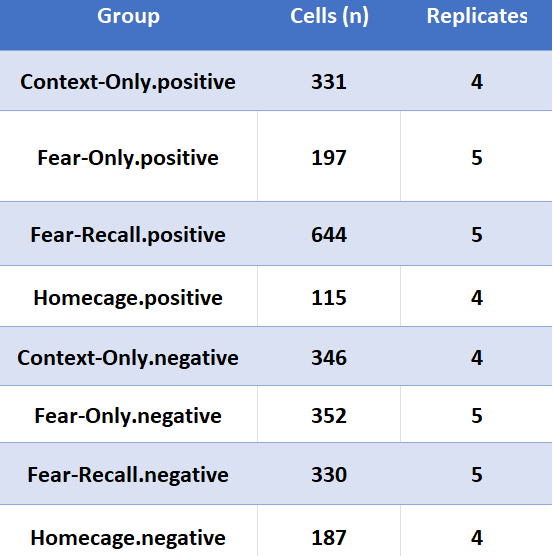

In [199]:
# now we can begin using edgeR and limma-voom for the analysis
bulk_glut <- DGEList(pseudobulk[,exctitatory_pseudobulk.idx ])
#predictors_bulk_glut <- pseudobulk_meta[exctitatory_pseudobulk.idx ,predictors_cols]
predictors_bulk_glut <- pseudobulk_meta[exctitatory_pseudobulk.idx ,]

In [165]:
bulk_glut <- calcNormFactors(bulk_glut)
logCPM <- cpm(bulk_glut, log=TRUE, prior.count=3)

In [167]:
# filter out lowly expressed genes
cutoff <- 1
drop <- which(apply(cpm(bulk_glut), 1, max) < cutoff)
bulk_glut <- bulk_glut[-drop,] 
dim(bulk_glut) # number of genes left

[1] 18398    38

In [327]:
# creating a variable for plotting
group <- interaction(predictors_bulk_glut$condition, predictors_bulk_glut$TRAPed)
#group <- as.character(group)
group <- gsub(pattern = '-', replacement = '', x = group)
#group <- gsub(pattern = '.', replacement = '', x = group)
group <- as.factor(group)

In [328]:
table(group)

group
ContextOnly.negative ContextOnly.positive    FearOnly.negative 
                   5                    5                    5 
   FearOnly.positive  FearRecall.negative  FearRecall.positive 
                   5                    5                    5 
   Homecage.negative    Homecage.positive 
                   4                    4 

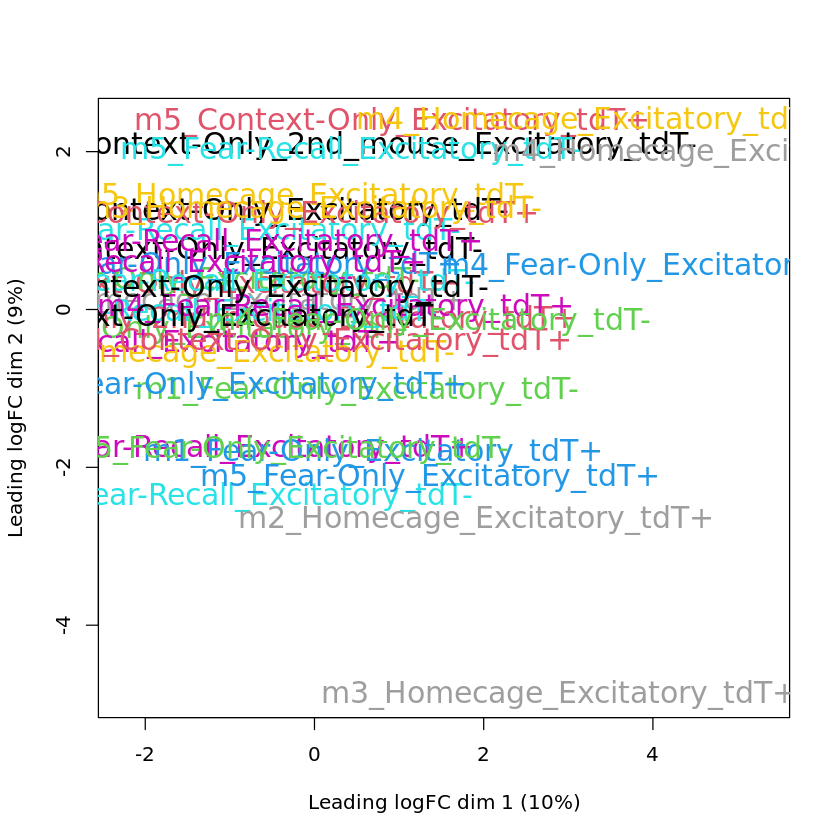

In [481]:
plotMDS(bulk_glut, col = as.numeric(group),cex = 1.5)

In [172]:
library(factoextra)
library(FactoMineR)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [210]:
pca.raw.bulk_glut <- log2(bulk_glut$counts+0.5)
pca.bulk_glut <- PCA(t(pca.raw.bulk_glut),graph = F)

Warning message:
"The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them."
Warning message:
"Removed 8 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."


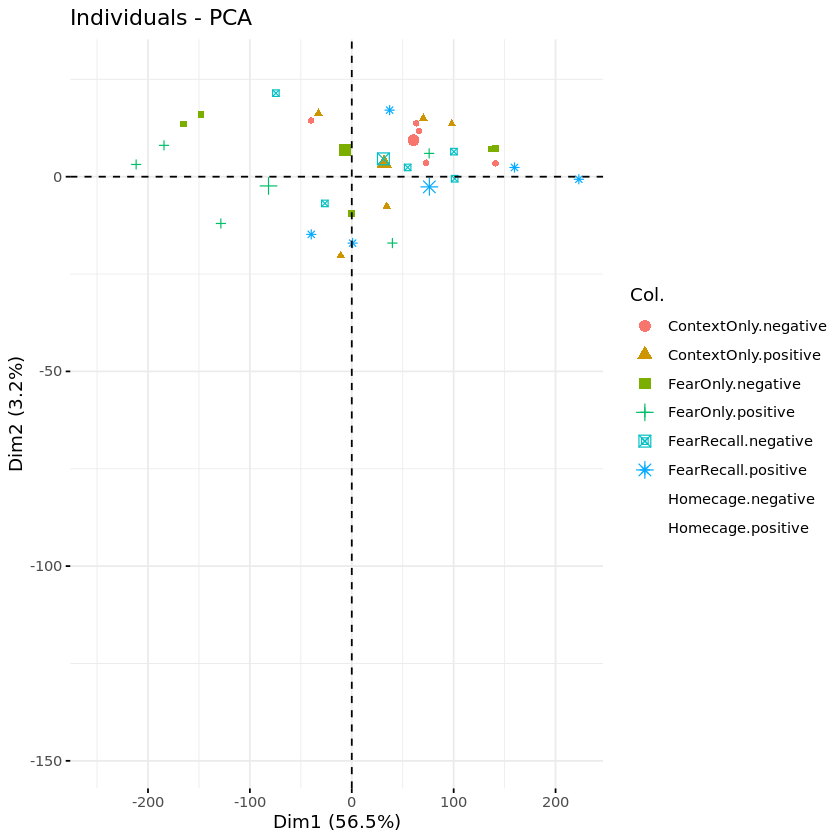

In [318]:
fviz_pca_ind(pca.bulk_glut, col.ind = group, geom ='point')

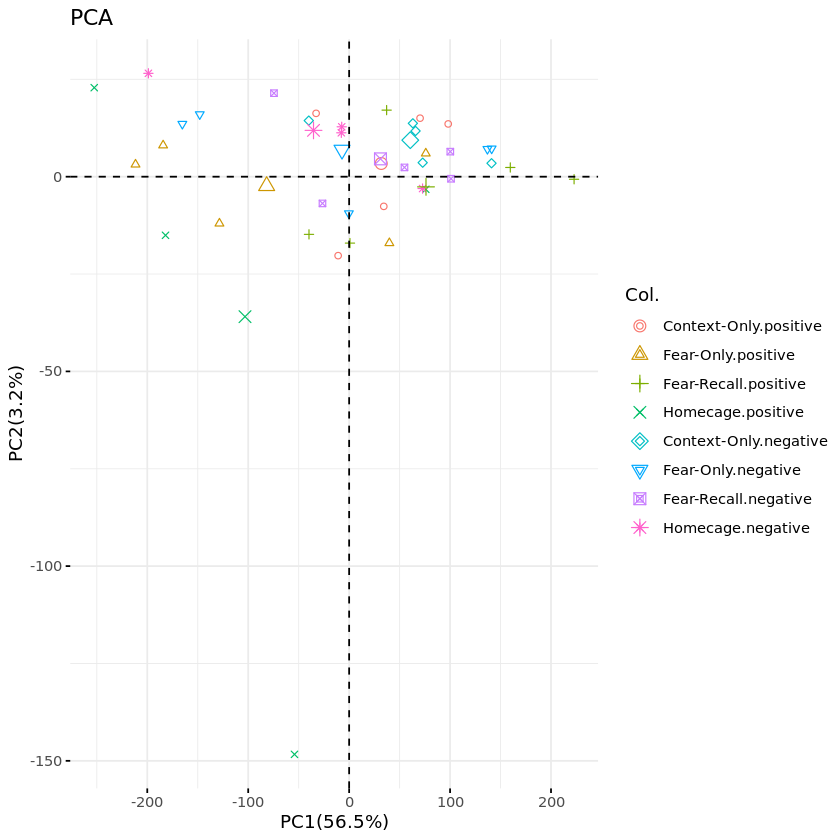

In [211]:
fviz_pca_ind(pca.bulk_glut, col.ind = group, geom ='point') +
  labs(title ="PCA", x = "PC1(56.5%)", y = "PC2(3.2%)")

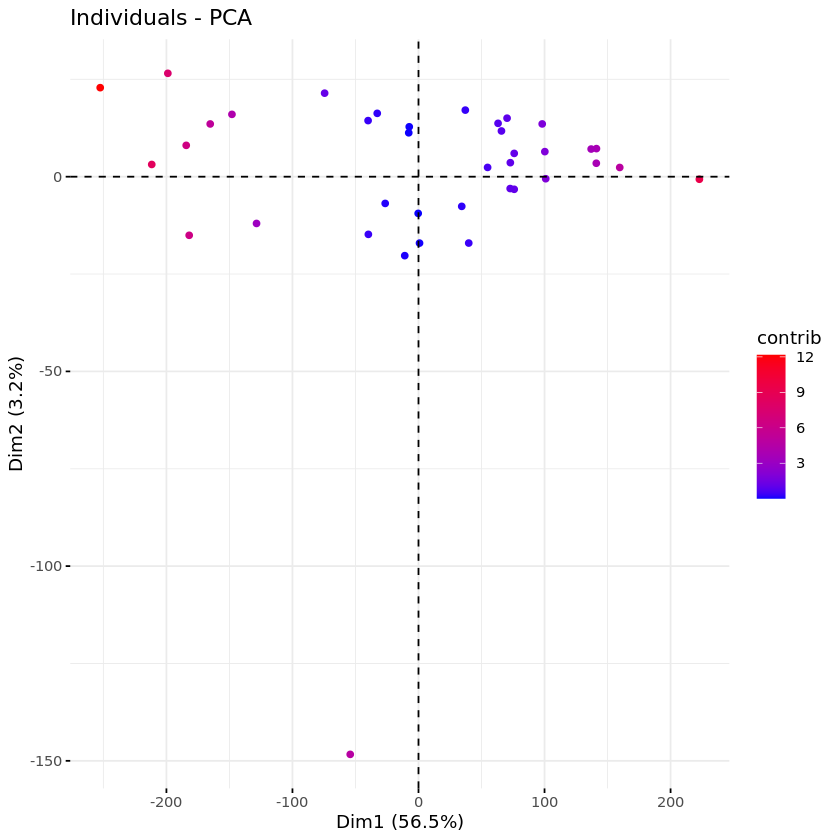

In [214]:
fviz_pca_ind(pca.bulk_glut, col.ind="contrib", geom = 'point') +
      scale_color_gradient2(low="white", mid="blue",
      high="red")

In [204]:
predictors_bulk_glut['m2_Homecage_Excitatory_tdT+','n_cells']

[1] 38

In [215]:
min(predictors_bulk_glut$n_cells)

[1] 3

In [269]:
components_correlation_to_genes <- dimdesc(pca.bulk_glut, axes=c(1,2))

In [276]:
na.omit(data.frame(components_correlation_to_genes$`Dim.1`) )

,quanti.correlation,quanti.p.value
,<dbl>,<dbl>
Gabarapl1,0.9954605,2.236151e-38
Oxct1,0.9942350,1.634852e-36
Eif4a1,0.9936098,1.037958e-35
Pgk1,0.9929888,5.482835e-35
Cops6,0.9925466,1.642821e-34
Sdhaf2,0.9924338,2.150678e-34
Zmat2,0.9923389,2.689908e-34
Tmem9b,0.9923134,2.854664e-34
Hras,0.9922685,3.169630e-34


In [363]:
replicate <- predictors_bulk_glut$replicate
replicate <- gsub(pattern = '-', replacement = '', x = replicate)
replicate <- as.factor(replicate)
condition <- predictors_bulk_glut$condition
condition <- gsub(pattern = '-', replacement = '', x = condition)
condition <- as.factor(condition)
TRAPed <- predictors_bulk_glut$TRAPed
TRAPed <- gsub(pattern = '-', replacement = '', x = TRAPed)
TRAPed <- as.factor(TRAPed)
environment_exposure <- predictors_bulk_glut$environment_exposure
environment_exposure <- gsub(pattern = '-', replacement = '', x = environment_exposure)
environment_exposure <- as.factor(environment_exposure)
fear <- predictors_bulk_glut$fear
fear <- gsub(pattern = '-', replacement = '', x = fear)
fear <- as.factor(fear)
recall <- predictors_bulk_glut$recall
recall <- gsub(pattern = '-', replacement = '', x = recall)
recall <- as.factor(recall)

In [321]:
# simple group model replicates as a facotr to control stuff
mm.groups <- model.matrix(~0 + replicate + group)
## now a more complex model with an interaction
mm.interactions <- model.matrix(~0 + replicate + condition:TRAPed)
# now an even more copmplicated interaction effect
mm.detailed_interactions <- model.matrix(~0 + replicate + TRAPed:environment_exposure:fear:recall )

In [232]:
is.factor(TRAPed)

[1] TRUE

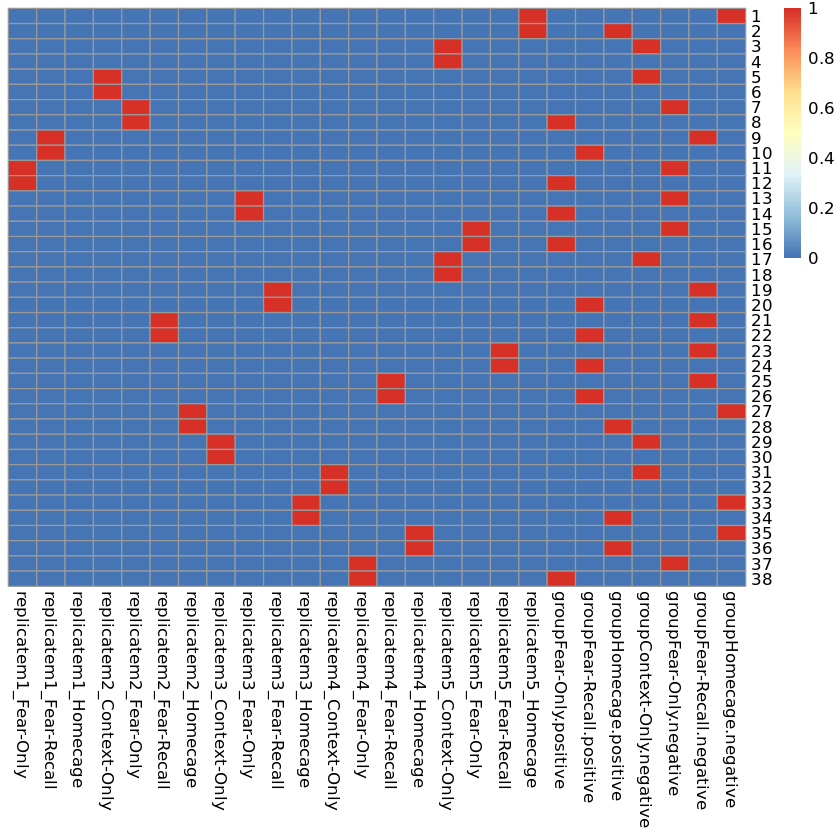

In [223]:
pheatmap(mm.groups ,cluster_rows = FALSE,cluster_cols = FALSE)

Coefficients not estimable: replicatem1_Homecage groupFear-Only.negative groupFear-Recall.negative groupHomecage.negative 


Warning message:
"Partial NA coefficients for 23355 probe(s)"


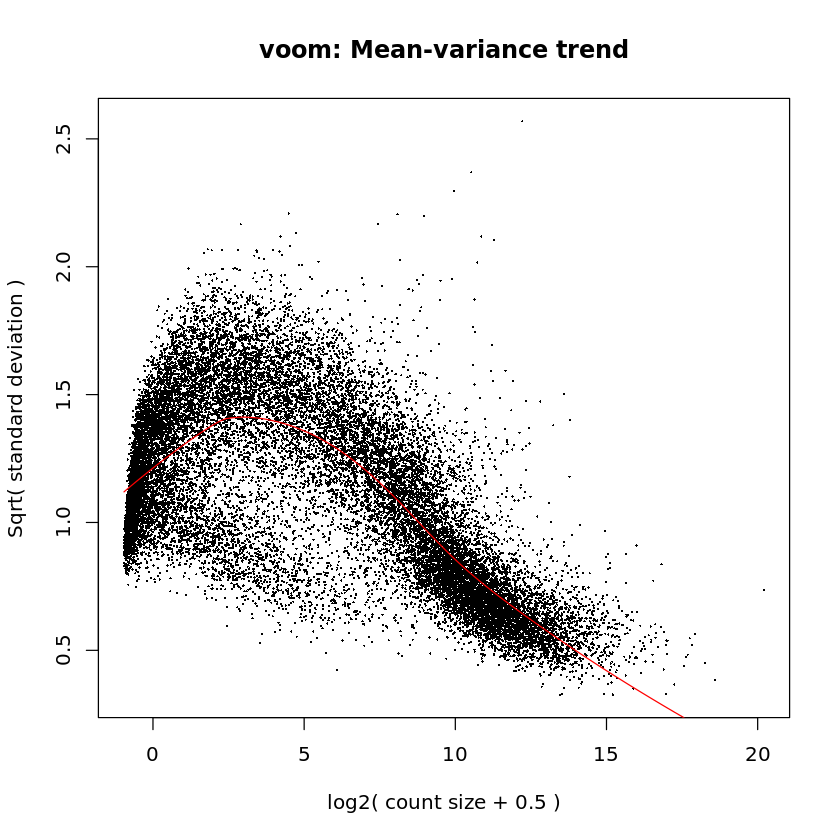

In [226]:
voom.y.bulk_glut <- voom(bulk_glut, mm.groups, plot = T)

In [228]:
fit <- lmFit(voom.y.bulk_glut, mm)
coef.fit <- fit$coefficients
head(coef(fit))

,groupContext-Only.positive,groupFear-Only.positive,groupFear-Recall.positive,groupHomecage.positive,groupContext-Only.negative,groupFear-Only.negative,groupFear-Recall.negative,groupHomecage.negative
00R-AC107638.2,-4.4964591,-4.259905,-5.243498,-3.1820291,-5.838939,-2.443499,-4.6157643,-5.228660
0610005C13Rik,-4.3073995,-3.782925,-5.439544,-3.7253300,-5.995870,-4.545306,-5.3994754,-5.349968
0610007P14Rik,6.5329598,6.796880,6.752576,6.5878632,6.863849,6.678535,6.7744667,6.882802
0610009B22Rik,6.1822780,6.427809,6.376309,6.9029661,6.255154,6.091574,6.2194006,6.172389
0610009E02Rik,-0.3947192,-2.189593,-1.755934,-1.5270139,-1.653842,-3.336190,-0.2979212,-1.700392
0610009L18Rik,1.7709382,1.502256,2.186312,0.2094219,2.123569,1.976544,2.4485788,1.949405


In [235]:
head(mm.detailed_interactions,5)

,replicatem1_Fear-Only,replicatem1_Fear-Recall,replicatem1_Homecage,replicatem2_Context-Only,replicatem2_Fear-Only,replicatem2_Fear-Recall,replicatem2_Homecage,replicatem3_Context-Only,replicatem3_Fear-Only,replicatem3_Fear-Recall,...,TRAPedpositive:environment_exposureTRUE:fearTRUE:recallFALSE,TRAPednegative:environment_exposureTRUE:fearTRUE:recallFALSE,TRAPedpositive:environment_exposureFALSE:fearFALSE:recallTRUE,TRAPednegative:environment_exposureFALSE:fearFALSE:recallTRUE,TRAPedpositive:environment_exposureTRUE:fearFALSE:recallTRUE,TRAPednegative:environment_exposureTRUE:fearFALSE:recallTRUE,TRAPedpositive:environment_exposureFALSE:fearTRUE:recallTRUE,TRAPednegative:environment_exposureFALSE:fearTRUE:recallTRUE,TRAPedpositive:environment_exposureTRUE:fearTRUE:recallTRUE,TRAPednegative:environment_exposureTRUE:fearTRUE:recallTRUE
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [237]:
fit.groups <- lmFit(voom.y.bulk_glut, mm.groups)
coef.fit.groups <- fit.groups$coefficients
head(coef(coef.fit.groups))

Coefficients not estimable: replicatem1_Homecage groupFear-Only.negative groupFear-Recall.negative groupHomecage.negative 


Warning message:
"Partial NA coefficients for 23355 probe(s)"


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': $ operator is invalid for atomic vectors


In [236]:
fit.interactions <- lmFit(voom.y.bulk_glut, mm.interactions)
coef.fit.interactions <- fit.interactions$coefficients
head(coef(coef.fit.interactions))

Coefficients not estimable: replicatem1_Homecage conditionContext-Only:TRAPednegative conditionFear-Only:TRAPednegative conditionFear-Recall:TRAPednegative conditionHomecage:TRAPednegative 


Warning message:
"Partial NA coefficients for 23355 probe(s)"


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': $ operator is invalid for atomic vectors


In [236]:
# this one doesn't even run,
fit.detailed_interactions <- lmFit(voom.y.bulk_glut, mm.detailed_interactions)
coef.fit.detailed_interactions <- fit.detailed_interactions$coefficients
head(coef(coef.fit.detailed_interactions))

I tried controlling for replicates but that seems to produce over parameterized models.  Paul asked me to do positives vs negatives as well as the.  This explanation of 2x4 design will help understand.

In [405]:
## now a more complex model with an interaction
mm_noreps.interactions <- model.matrix(~0 +condition + condition:TRAPed)

fit_noreps.interactions <- lmFit(voom.y.bulk_glut, mm_noreps.interactions )
coef.fit_noreps.interactions <- fit_noreps.interactions$coefficients
head(coef(fit_noreps.interactions))

,conditionContextOnly,conditionFearOnly,conditionFearRecall,conditionHomecage,conditionContextOnly:TRAPedpositive,conditionFearOnly:TRAPedpositive,conditionFearRecall:TRAPedpositive,conditionHomecage:TRAPedpositive
00R-AC107638.2,-5.838939,-2.443499,-4.6157643,-5.228660,1.34247943,-1.8164057,-0.62773347,2.0466308
0610005C13Rik,-5.995870,-4.545306,-5.3994754,-5.349968,1.68847071,0.7623812,-0.04006890,1.6246384
0610007P14Rik,6.863849,6.678535,6.7744667,6.882802,-0.33088907,0.1183455,-0.02189084,-0.2949390
0610009B22Rik,6.255154,6.091574,6.2194006,6.172389,-0.07287555,0.3362346,0.15690843,0.7305766
0610009E02Rik,-1.653842,-3.336190,-0.2979212,-1.700392,1.25912299,1.1465971,-1.45801284,0.1733778
0610009L18Rik,2.123569,1.976544,2.4485788,1.949405,-0.35263084,-0.4742889,-0.26226671,-1.7399833


In [406]:
# we devide the positives in the other conditions in the other 
fit <- contrasts.fit(fit_noreps.interactions, c(0,0,0,0,-1/3,-1/3,1,-1/3))

In [411]:
top100 <- topTable(eBayes(fit), adjust.method="BH", number = 100)
head(top100,5)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rpl3,-0.4807881,9.497238,-4.906802,2.231327e-05,0.3021027,2.27218189
Fbll1,-1.1947752,4.052840,-4.327248,1.241381e-04,0.4274291,0.57702678
Snap91,0.5789676,7.079463,4.056517,2.726935e-04,0.5789779,0.39395588
Gpm6a,0.6281827,10.205777,4.230421,1.647126e-04,0.4274291,0.04582651
Eif6,-0.6473804,7.323707,-3.820885,5.350679e-04,0.6971431,-0.27141668


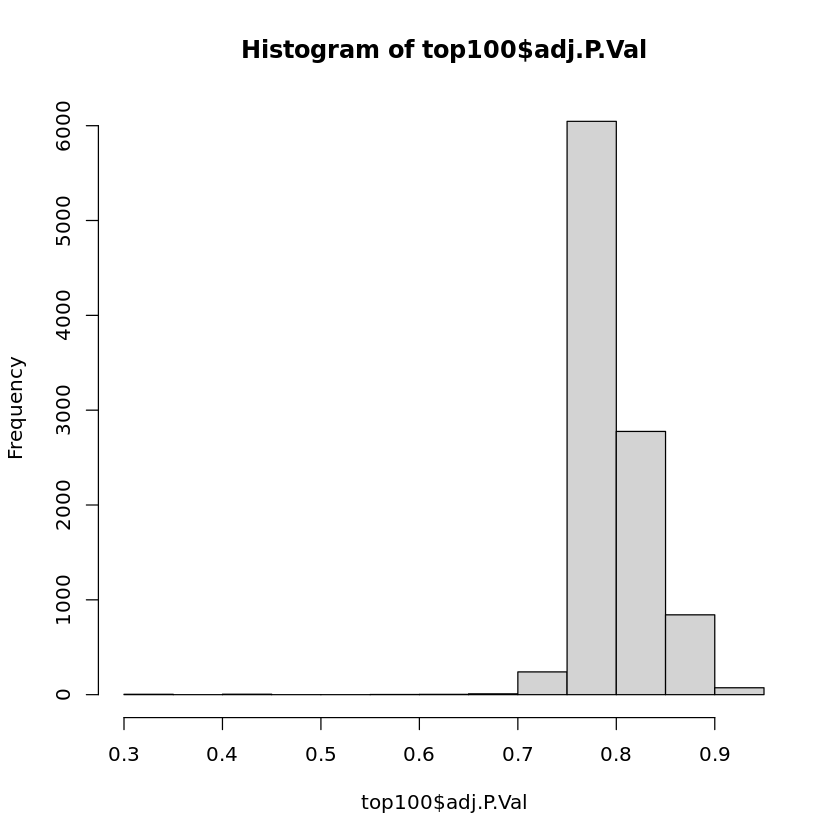

In [399]:
hist(top100$adj.P.Val)

In [401]:
rownames(top100)

[1] "Rpl3"            "Fbll1"           "Snap91"          "Gpm6a"          
    [5] "Eif6"            "Sgtb"            "Dynlt3"          "Bex2"           
    [9] "Tnmd"            "Gtf2b"           "Arntl"           "Ndrg4"          
   [13] "Cops7b"          "Tmem30a"         "Wdr47"           "Olfml2b"        
   [17] "Bcas1"           "1700001G11Rik"   "Zfp595"          "Ubr4"           
   [21] "Ccdc28b"         "Csnk2b"          "Gsta2"           "Lrrc20"         
   [25] "Mysm1"           "Letm1"           "Rbm43"           "Naa35"          
   [29] "Cbr1"            "Sike1"           "Sec24c"          "Acsl5"          
   [33] "Skap2"           "Magoh"           "Chpf2"           "Pigyl"          
   [37] "Herpud2"         "Pfdn2"           "Atg5"            "Zfp995"         
   [41] "Pex11g"          "Pfdn6"           "Ptger3"          "Slc37a1"        
   [45] "Dap"             "Zfp143"          "Ost4"            "Dnd1"           
   [49] "Afg3l2"          "Naa38"           "Vill"            "Cox6a2"         
   [53] "Ppp3r1"          "Ppa2"            "Apba2"           "Psmb5"          
   [57] "Arap2"           "Ankrd52"         "Nup88"           "Cox16"          
   [61] "Bzw1"            "Rpl21"           "Lingo3"          "Hist2h2ac"      
   [65] "Aph1a"           "Rpl7a"           "Nomo1"           "TdTom-transgene"
   [69] "Wee1"            "Gm19967"         "Kcnc4"           "Paf1"           
   [73] "Emb"             "Fry"             "Gm43727"         "2810403A07Rik"  
   [77] "Adam10"          "Orai3"           "Fkbp2"           "Rnf112"         
   [81] "Zfp398"          "Gm15427"         "Maob"            "Wdr5b"          
   [85] "Tspo"            "Pfkfb2"          "Pth1r"           "Nol6"           
   [89] "Crybb3"          "Rps25"           "Mtpn"            "Stard10"        
   [93] "Ccdc114"         "Cdk12"           "Sgpp2"           "Cdc26"          
   [97] "Gm9801"          "Adcy1"           "Pitpnb"          "Map3k4"         
  [101] "Adck5"           "Pcdhb22"         "Bptf"            "Rpl3-ps1"       
  [105] "Rdh10"           "Mta2"            "Wdr26"           "Atrn"           
  [109] "Hmgxb3"          "Tmem175"         "Gm38146"         "Tial1"          
  [113] "Rps27a"          "Slc20a2"         "Trerf1"          "Ankrd40"        
  [117] "Sntg2"           "Cckbr"           "Nol8"            "Arhgef4"        
  [121] "Plaa"            "Cwc15"           "Atp8b3"          "Usp11"          
  [125] "Rpl32"           "Use1"            "Sec14l1"         "Itpr3"          
  [129] "Fbxw11"          "Srsf6"           "Tvp23a"          "Mblac2"         
  [133] "Zfp51"           "Usp29"           "Zswim7"          "Hfe2"           
  [137] "Ankle2"          "Ppp1r3c"         "Mrpl43"          "Rragd"          
  [141] "Pramef8"         "Gm38359"         "Gm44684"         "Gclc"           
  [145] "Gcn1l1"          "Ccna1"           "Gucy1a2"         "Slc35d3"        
  [149] "Mapkapk2"        "Grin3a"          "Gm37354"         "Dyrk1a"         
  [153] "Fis1"            "Vmac"            "Jak3"            "Taf4b"          
  [157] "5330438D12Rik"   "Gpatch3"         "Rps13"           "Ctbs"           
  [161] "C230085N15Rik"   "Nol12"           "Kif7"            "Gpr137c"        
  [165] "Gm26881"         "Pde4a"           "Sorl1"           "Zfp938"         
  [169] "Fam32a"          "Adm"             "Slc25a40"        "Stac"           
  [173] "Apobec3"         "Gm8152"          "Serp1"           "Gm16110"        
  [177] "Tspan6"          "Per1"            "Casq2"           "Usp6nl"         
  [181] "Notch4"          "Mrs2"            "Adss"            "Gm6863"         
  [185] "Klk8"            "Pcdhb21"         "Spata6"          "Adam17"         
  [189] "Slc16a7"         "Lrg1"            "Chn2"            "Mamdc4"         
  [193] "Zfp408"          "Gpr158"          "Ska3"            "Abcb4"          
  [197] "Gm12915"         "Tro"             "Abcc8"           "Wdtc1"          
  [2

The **fit_noreps.groups** and **fit_noreps.interactions** both work.  Get the DEG lists for the postive vs negative cells for each group and see if the Fear-Recall is different.

In [408]:
# We devide our comparissons by 4 in both cases so we can get the mean of positives vs negatives
fit_negvspos <- contrasts.fit(fit_noreps.interactions, c(-1/4,-1/4,-1/4,-1/4,1/4,1/4,1/4,1/4))

In [412]:
top100_negvspos <- topTable(eBayes(fit_negvspos), adjust.method="BH", number = 100)
head(top100_negvspos)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Snrpn,-11.649703,11.653109,-236.0765,1.367613e-56,3.194061e-52,119.5139
Cdc42,-9.964096,9.902377,-223.8811,8.401250e-56,9.810560e-52,113.4590
Mdh1,-11.656437,11.576549,-183.4424,7.671089e-53,4.478957e-49,111.0782
Syt11,-10.131758,10.022283,-186.5786,4.295088e-53,3.343726e-49,109.3709
mt-Rnr2,-12.990867,13.275324,-171.1298,8.262561e-52,3.806477e-48,107.9776
Calm2,-12.652140,12.943369,-170.2889,9.779003e-52,3.806477e-48,107.9040


In [413]:
fit_fearrecal_posvsneg <- contrasts.fit(fit_noreps.interactions, c(0,0,-1,0,0,0,1,0))

In [414]:
top100_fearrecal_posvsneg <- topTable(eBayes(fit_fearrecal_posvsneg), adjust.method="BH", number = 100)
head(top100_fearrecal_posvsneg)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Snrpn,-11.837858,11.653109,-156.7353,1.668390e-50,3.896525e-46,105.46992
Mdh1,-11.815422,11.576549,-121.3388,1.053529e-46,8.201722e-43,96.93568
Cdc42,-9.986701,9.902377,-136.3972,1.932997e-48,2.257258e-44,96.42688
Syt11,-10.081878,10.022283,-110.8833,2.288316e-45,1.336090e-41,91.57399
mt-Co1,-12.443412,12.317668,-101.2350,5.122154e-44,1.993798e-40,90.64344
mt-Rnr2,-13.102935,13.275324,-102.7493,3.085563e-44,1.441266e-40,90.55759


In [445]:
gene_filter <-function(df_toptable){
    # DEG lsit from a topTable function, takes df of any size
    return(df_toptable[ abs(df_toptable$logFC)>0.3 & df_toptable$adj.P.Val<0.01,])
    }

In [ ]:
top_FR_posvsneg <- topTable(eBayes(fit_fearrecal_unique), adjust.method="BH", number = 20000)

In [ ]:
dim(gene_filter(top_FR_posvsneg))

[1] 16463     6

In [436]:
#print(sum(abs(df_toptable)>0.3 & df_toptable$adj.P.Val<0.05) )
#dim(df_toptable[ abs(df_toptable)>0.3 & df_toptable$adj.P.Val<0.05,])
print(sum(abs(df_toptable$logFC)>0.3 & df_toptable$adj.P.Val<0.05) )

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'print': object 'df_toptable' not found


In [433]:
#top_FR_posvsneg <- gene_filter(top_FR_posvsneg)
dim(top_FR_posvsneg)

[1] 20000     6

To be fair the authors did say that some of these effects are cell type specific so prehaps these are being washed out in our model.  

In [426]:
sum(df_toptable[ abs(df_toptable$logFC)>0.3 & df_toptable$adj.P.Val<0.05,])

[1] 10000

In [ ]:
# conditionContextOnly conditionFearOnly conditionFearRecall conditionHomecage
# conditionContextOnly:TRAPedpositive conditionFearOnly:TRAPedpositive conditionFearRecall:TRAPedpositive conditionHomecage:TRAPedpositive

In [447]:
# we will skip this two  criteria as we can simply bulk it and this will be met, no need to recompute for each mouse
# First, DEGs are recalculated by assessing each experiment individually using the whole transcriptome, 
# and only DEGs (via the same criteria as pooled) that intersect in three-quarters of replicates are kept. 

In [483]:
# ...our list of DEGs (FR TRAP versus NF TRAP results in 1,291 DEGs, cells from 4 biological replicates pooled, logFC > 0.3, FDR < 0.01) 
# conditionContextOnly conditionFearOnly conditionFearRecall conditionHomecage
# conditionContextOnly:TRAPedpositive conditionFearOnly:TRAPedpositive conditionFearRecall:TRAPedpositive conditionHomecage:TRAPedpositive
fit_FRvsNF_TRAP  <- contrasts.fit(fit_noreps.interactions, c(0,0,0,0,-1,0,1,0))
top_FRvsNF_TRAP <- topTable(eBayes(fit_FRvsNF_TRAP  ), adjust.method="BH", number = 20000)
top_FRvsNF_TRAP <- gene_filter(top_FRvsNF_TRAP)
dim(top_FRvsNF_TRAP)

[1] 0 6

In [447]:
# All resulting DEGs are found in the initial DEG list (all replicates pooled), 
# indicating that no additional DEGs were found as a result of analysing replicates separately.

In [457]:
# Second, ‘inactive’ (tdT-negative) populations were also compared (FR inactive versus NF inactive)
# and any DEGs that intersected with the DEGs left after the first criteria, were removed.
fit_FRvsNF_inactive  <- contrasts.fit(fit_noreps.interactions, c(-1,0,1,0,0,0,0,0))
top_FRvsNF_inactive <- topTable(eBayes(fit_FRvsNF_inactive ), adjust.method="BH", number = 20000)
top_FRvsNF_inactive <- gene_filter(top_FRvsNF_inactive)
dim(top_FRvsNF_inactive)

[1] 0 6

In [454]:
# this one doesn't even fit at all
fit_FRvsHC_inactive  <- contrasts.fit(fit_noreps.interactions, c(0,0,1,-1,0,0,0,0))
top_FRvsHC_inactive <- topTable(eBayes(fit_FRvHC_inactive ), adjust.method="BH", number = 20000)
top_FRvsHC_inactive <- gene_filter(top_FRvsHC_inactive)
dim(top_FRvsHC_inactive)

ERROR: Error in .ebayes(fit = fit, proportion = proportion, stdev.coef.lim = stdev.coef.lim, : object 'fit_FRvHC_inactive' not found


In [455]:
# this one doesn't fit either
fit_FRvsNR_inactive  <- contrasts.fit(fit_noreps.interactions, c(0,-1,1,0,0,0,0,0))
top_FRvsNR_inactive <- topTable(eBayes(fit_FRvNR_inactive ), adjust.method="BH", number = 20000)
top_FRvsNR_inactive <- gene_filter(top_FRvsNR_inactive)
dim(top_FRvsNR_inactive)

ERROR: Error in .ebayes(fit = fit, proportion = proportion, stdev.coef.lim = stdev.coef.lim, : object 'fit_FRvNR_inactive' not found


This second step yeild no DEGs whatsoever.  

In [477]:
#  Third, the remaining DEGs had to be differentially expressed when FR TRAP was compared to either NR TRAP or HC TRAP.
# conditionContextOnly conditionFearOnly conditionFearRecall conditionHomecage
# conditionContextOnly:TRAPedpositive conditionFearOnly:TRAPedpositive conditionFearRecall:TRAPedpositive conditionHomecage:TRAPedpositive
fit_FRvsNR  <- contrasts.fit(fit_noreps.interactions, c(0,0,0,0,0,-1,1,0))
top_FRvsNR  <- topTable(eBayes(fit_FRvsNR), adjust.method="BH", number = 20000)
top_FRvsNR  <- gene_filter(top_FRvsNR )
print(dim(top_FRvsNR  ))
fit_FRvsHC  <- contrasts.fit(fit_noreps.interactions, c(0,0,0,0,0,0,1,-1))
top_FRvsHC  <- topTable(eBayes(fit_FRvsHC ), adjust.method="BH", number = 20000)
top_FRvsHC  <- gene_filter(top_FRvsHC )
print(dim(top_FRvsHC ))
fit_FRvsNF  <- contrasts.fit(fit_noreps.interactions, c(0,0,0,0,-1,0,1,0))
top_FRvsNF  <- topTable(eBayes(fit_FRvsNF), adjust.method="BH", number = 20000)
top_FRvsNF  <- gene_filter(top_FRvsNF)
print(dim(top_FRvsNF ))

[1] 0 6
[1] 0 6
[1] 0 6


These comparissons also yeild no DEGs so it's not like they end up producing anything useful.  But it also implies there are no DEGs specific to any particular active group.

In [478]:
makeContrasts()

In [478]:
controlcontrasts <- c(fit_FRvsNR = c(0,0,0,0,0,-1,1,0),
  fit_FRvsHC = c(0,0,0,0,0,0,1,-1),
  fit_FRvsNF = c(0,0,0,0,-1,0,1,0) )

In [447]:
# Last, the remaining DEGs must pass a permutation test in which the training labels are shuffled and a distribution of log2FC 
# is computed based on these labels. The true observed logFC must be above the 95th percentile of the distribution of 
# the shuffled distribution. After placing these constraints, 99 genes remain from the original list of 1,291.

First Attempt at gettin an FR unique list, gives us 100 DEGs which don't appear in the lsit of all 

In [462]:
# what paul wants is this....
fit_fearrecal_unique  <- contrasts.fit(fit_noreps.interactions, c(0,0,-1,0,0,0,1,0))
top_FR_posvsneg <- topTable(eBayes(fit_fearrecal_unique), adjust.method="BH", number = 20000)
top_FR_posvsneg <- gene_filter(top_FR_posvsneg)
dim(top_FR_posvsneg)

[1] 13696     6

In [468]:
fit_posvsneg  <- contrasts.fit(fit_noreps.interactions, c(-1/3,-1/3,0,-1/3,1/3,1/3,0,1/3))
top_posvsneg <- topTable(eBayes(fit_posvsneg), adjust.method="BH", number = 20000)
top_posvsneg <- gene_filter(top_posvsneg)
dim(top_posvsneg)

[1] 18326     6

In [469]:
FR_unique <- top_FR_posvsneg[!(rownames(top_FR_posvsneg) %in% rownames(top_posvsneg)),]
dim(FR_unique)
head(FR_unique)

[1] 305   6

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gm6863,-2.547229,2.119236,-5.269654,7.522191e-06,2.259560e-05,3.556531
5330438D12Rik,-3.952309,2.300691,-5.157952,1.051895e-05,3.123587e-05,3.315860
Gm44684,9.259738,-2.576923,5.358263,5.763944e-06,1.741487e-05,3.163483
Dbt,-4.119162,2.231544,-5.065889,1.386272e-05,4.079171e-05,3.102702
Gm9843,-2.591357,2.425736,-4.998938,1.694020e-05,4.944243e-05,2.879353
Gm43318,-3.793708,3.231385,-4.955916,1.926697e-05,5.605134e-05,2.825299


In [474]:
top_FR_posvsneg$

In [474]:
#Lets do the upregulated genes
bestmrkers <- FR_unique[ (FR_unique$logFC>0)&(FR_unique$adj.P.Val<0.001),] %>% arrange(desc(logFC))
head(bestmrkers,10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Itih5,12.54327,-2.4995039,4.011601,3.103457e-04,7.377977e-04,0.1644295
Adm,11.70871,-1.8899191,4.054934,2.739407e-04,6.612118e-04,0.2549962
Rrad,11.39068,-0.8442292,4.659959,4.653768e-05,1.298241e-04,1.7561601
Gsta2,11.25936,-1.7860850,4.510199,7.249408e-05,1.963697e-04,1.4051248
Lrg1,11.21798,-3.4305703,4.442322,8.855003e-05,2.364338e-04,1.1163443
Ndst4,11.10491,-2.4951002,4.615078,5.316190e-05,1.471957e-04,1.4720344
Tnmd,10.93738,-1.1086261,4.231447,1.642210e-04,4.177066e-04,0.6981375
Tspo,10.74223,-3.4599547,4.733013,3.745864e-05,1.056706e-04,1.7545033
Fgfrl1,10.44853,-3.3819611,5.138115,1.116390e-05,3.307953e-05,2.7000263


In [ ]:
# to ensure these are unique I will then do the same thing they did before
fit_fearrecal_unique  <- contrasts.fit(fit_noreps.interactions, c(-1,0,0,0,1,0,0,0))
top_FR_posvsneg <- topTable(eBayes(fit_fearrecal_unique), adjust.method="BH", number = 20000)
top_FR_posvsneg <- gene_filter(top_FR_posvsneg)
dim(top_FR_posvsneg)
fit_fearrecal_unique  <- contrasts.fit(fit_noreps.interactions, c(0,0,-1,0,0,0,1,0))
top_FR_posvsneg <- topTable(eBayes(fit_fearrecal_unique), adjust.method="BH", number = 20000)
top_FR_posvsneg <- gene_filter(top_FR_posvsneg)
dim(top_FR_posvsneg)
fit_fearrecal_unique  <- contrasts.fit(fit_noreps.interactions, c(0,0,-1,0,0,0,1,0))
top_FR_posvsneg <- topTable(eBayes(fit_fearrecal_unique), adjust.method="BH", number = 20000)
top_FR_posvsneg <- gene_filter(top_FR_posvsneg)
dim(top_FR_posvsneg)

In [ ]:
read.table()

In [3]:
# normalization methods, we wont even use these

# paul prefers a log base that's easy to do headmath with so no eulers numebr
pseudocount_log2p1_transform <- function(x, scale_factor = 10000, UMI.provided = NULL){
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x+1)/counts
  x <- x/scale_factor
  return(log2(x))
}

pavlab.normalize <- function(df, UMI = NULL){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
#
   df[] <- Map(pseudocount_log2p1_transform, df, UMI.provided = UMI)
  
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}